In [2]:
import os
import sys
from argparse import ArgumentParser
from argparse import RawTextHelpFormatter

import numpy as np
from scipy import stats
import numpy.ma as ma
from pyrap import tables

from astropy import constants as const
import astropy.time as at

import matplotlib as mpl
#mpl.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [111]:
def get_ms_freqs(ms_table):
    t_spec_win = tables.table(ms_table.getkeyword('SPECTRAL_WINDOW'), readonly=True, ack=False)
    freqs = t_spec_win.getcol('CHAN_FREQ').squeeze()
    bw = t_spec_win.getcol('CHAN_WIDTH').squeeze()
    t_spec_win.close()
    return freqs

def get_metadata(ms_file):

    t    = tables.table(ms_file)
    time = np.unique(t.getcol('TIME'))    
    N_t  = len(time)
    N_A  = len(np.unique(t.getcol('ANTENNA1')))
    N_b  = len(t.getcol('UVW'))#N_A*(N_A+1)/2.
    Nu   = get_ms_freqs(t)
    N_f  = np.size(Nu)
    uvw  = np.reshape(t.getcol('UVW'),(N_t,N_b,3))
    flag = np.reshape(t.getcol('FLAG'),(N_t,N_b,N_f,4))[:,:,0,0]
    
    
#     uvw  = t.getcol('UVW')
#     flag = t.getcol('FLAG')[:,:,0,0]
    
    t.close()

    return uvw, N_b, N_t, N_f, Nu, flag
#     return uvw, N_b, N_t, N_f, flag



AttributeError: 'AxesSubplot' object has no attribute 'set_zlabel'

Successful readonly open of default-locked table /data/low_band_avg.filter.ms: 24 columns, 123695 rows
[162 166 186 206 187 203 204 164 180 167 150 150 156 138 131 143 131 134
 128 125  87 119 122 105  96 114 107  97 109  85  98  90  83  78  94  64
  72  70  71  80  82  45  47  49  58  38  36  47  49  37  37  20  25  22
  28  18  20  19  20  22  10  10  18  19  20  18  16  17  20  27  32  32
  39  31  41  43  56  51  54  51  70  52  64  73  66  62  77  77  76  77
  79  85  93  79  95  92 102  99  95 106 118 131  99 122 135 123 130 129
 140 131 140 134 153 140 148 143 158 133 150 159 138 139 169 149 189 166
 186 148 177 186 160 148 170 182 176 174 186 177 204 161 165 187 174 185
 185 176 176 180 208 191 171 198 190 182 199 163 193 191 178 188 165 168
 211 169 165 153 173 167 167 166 170 167 161 179 163 213 188 194 187 212
 194 221 217 233 248 248 258 242 295 271 282 249 302 248 286 269 256 253
 265 253 246 241 279 240 240 222 221 202 207 211 199 178 179 219 172 198
 208 211 202 185 203 

<IPython.core.display.Javascript object>


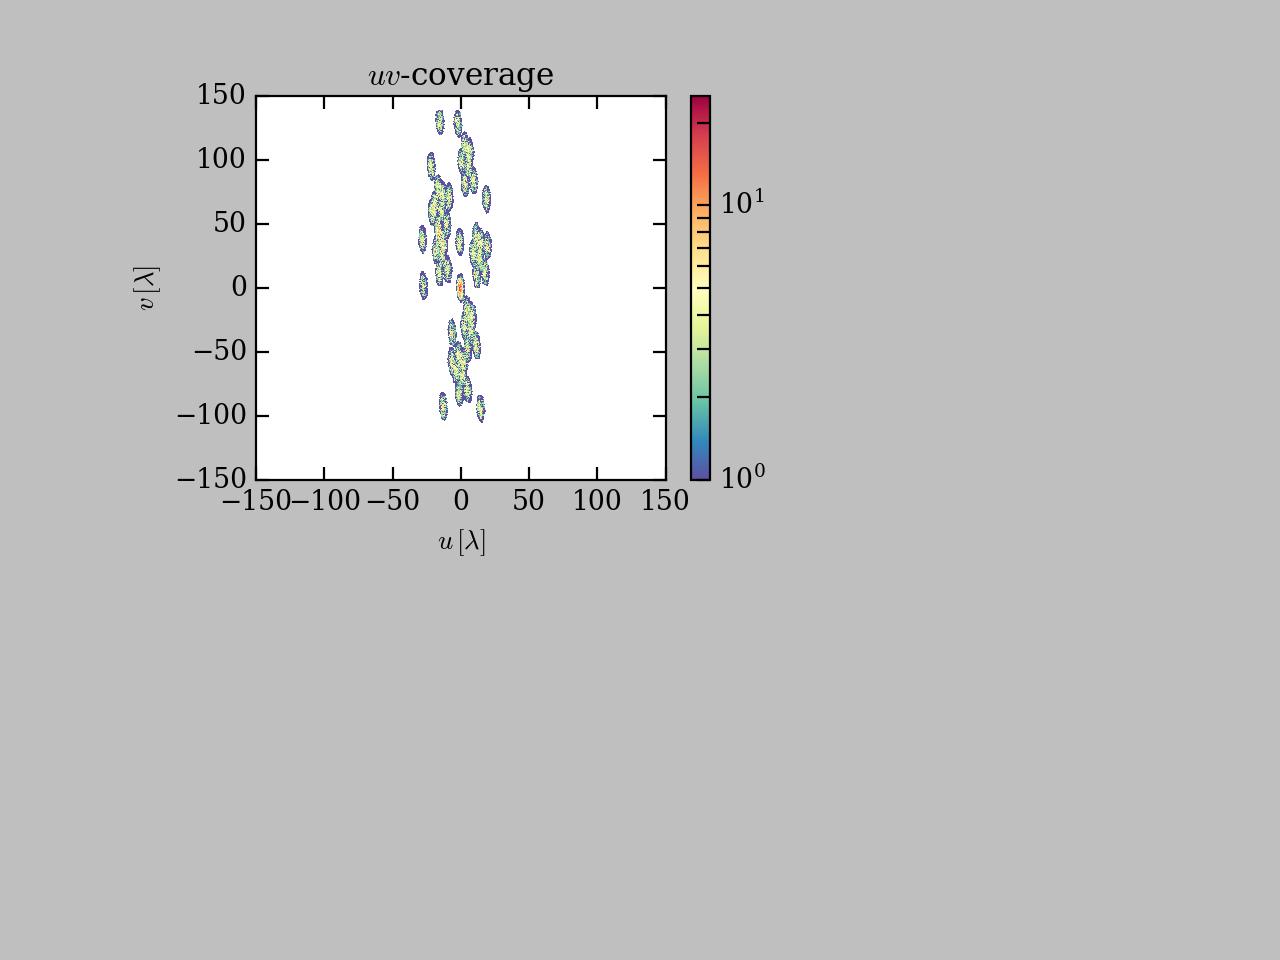

<IPython.core.display.Javascript object>


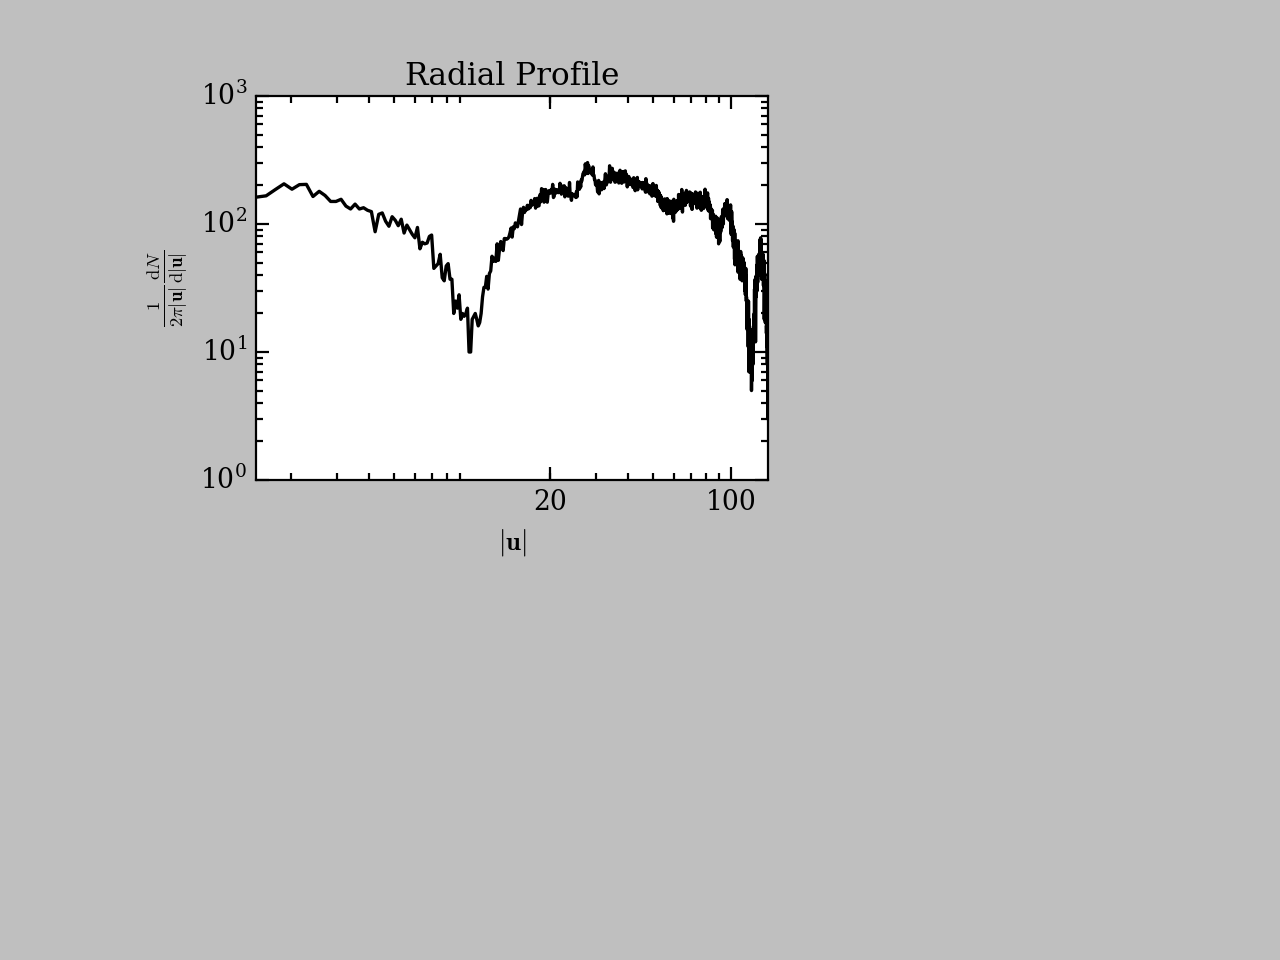

In [175]:
%tb
parser = ArgumentParser(description="Plot uv-coverage",
                        formatter_class=RawTextHelpFormatter)
parser.add_argument('--msname', help='measurement set list',required=True,nargs='*')
parser.add_argument('--umin', help='Minimum baseline in meters', type=float, default=10)
parser.add_argument('--umax', help='Maximum baseline in meters', type=float, default=1300)
parser.add_argument('--du', help='Baseline binning interval', type=float, default=10)


# def main():
# args = parser.parse_args(sys.argv[1:])
fname = "/data/low_band_avg.filter.ms"

uvw, N_b, N_t, N_f, Nu, flag = get_metadata(fname)

lmbda = 3.e8/np.mean(Nu)
umin  = 10./lmbda
umax  = 1000./lmbda
du    = 1./lmbda

mask = flag.astype(int)

UU = np.sqrt(uvw[:,:,0]**2+uvw[:,:,1]**2)/lmbda

Nbin = int(umax/du)

UV_hist, xedges,yedges = np.histogram2d((uvw[:,:,0].flatten())/lmbda,(uvw[:,:,1].flatten())/lmbda,
                                        range=[[-umax,umax], [-umax,umax]], bins=Nbin, weights=mask.flatten()) #

UU_hist, u_edges = np.histogram(UU.flatten(), bins=Nbin, range=(umin, umax), weights=mask.flatten())

print UU_hist

uu, vv = np.meshgrid(xedges[:-1],yedges[:-1])


mpl.style.use('classic')

mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
#mpl.rcParams['axes.grid'] = True

mpl.rcParams['xtick.major.size']  = 6
mpl.rcParams['ytick.major.size']  = 6
mpl.rcParams['xtick.minor.size']  = 3
mpl.rcParams['ytick.minor.size']  = 3
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['font.family'] = 'serif'


fig1, ax1 = plt.subplots(ncols=1, nrows=1)
fig1.subplots_adjust(left=0.2,top=0.9,right=0.6,bottom=0.5,wspace=0.05,hspace=0.05)

#ax1, ax2 = axs

ax1.set_title(r"$uv$-coverage",fontsize=14)
ax1.set_xlabel(r"$u\,[\lambda]$",fontsize=12)
ax1.set_ylabel(r"$v\,[\lambda]$",fontsize=12)
#ax1.set_xlim(-umax,umax)
#ax1.set_ylim(-umax,umax)

axim1 = ax1.pcolormesh(uu,vv,UV_hist,norm=LogNorm())
cbar1 = fig1.colorbar(axim1,ax=ax1)

fig2, ax2 = plt.subplots(ncols=1, nrows=1)
fig2.subplots_adjust(left=0.2,top=0.9,right=0.6,bottom=0.5,wspace=0.05,hspace=0.05)

ax2.set_title(r"Radial Profile",fontsize=14)
ax2.set_xlabel(r"$|\mathbf{u}|$",fontsize=12)
ax2.set_ylabel(r"$\frac{1}{2\pi|\mathbf{u}|}\frac{\mathrm{d}N}{\mathrm{d}|\mathbf{u}|}$",fontsize=12)

# ax2.set_xlim(20,500)

ax2.set_xscale('log')
ax2.set_xticks([20,100,500])
ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax2.semilogy(0.5*(u_edges[:-1] + u_edges[1:]),UU_hist,lw=1.5,c='k')

fig1.savefig('lofar_lba_uvcov.png',dpi=300, bbox_inches='tight')
fig2.savefig('lofar_lba_uvprof.png',dpi=300, bbox_inches='tight')
plt.show()

In [128]:
mask 

array([[0, 0, 0, ..., 0, 0, 0]])

In [114]:
fname = "/data/low_band_avg.filter.ms"
uvw, N_b, N_t, N_f, Nu, flag = get_metadata(fname)

Successful readonly open of default-locked table /data/low_band_avg.filter.ms: 24 columns, 123695 rows


In [115]:
print uvw, N_b, N_t, N_f, Nu, flag

[[[  1.37351208e+02   9.92808326e+01  -3.81551034e+02]
  [  1.33726061e+02   1.03425173e+02  -3.96066886e+02]
  [  1.42941539e+02   1.06532429e+02  -4.08919874e+02]
  ..., 
  [ -1.62582738e+01   2.13168075e-01   1.90907299e+00]
  [ -3.92285183e+01   1.08417628e+01  -3.30566218e+01]
  [ -2.29702446e+01   1.06285947e+01  -3.49656948e+01]]] 123695 1 6 [ 41048177.08333334  41308593.75        41569010.41666666
  41829427.08333334  42089843.75        42350260.41666666] [[ True  True  True ...,  True  True  True]]


In [26]:
t    = tables.table(fname)

uvw  = np.reshape(t.getcol('UVW'), (N_t,N_b,3))

Successful readonly open of default-locked table /data/low_band_avg.filter.ms: 24 columns, 123695 rows


ValueError: total size of new array must be unchanged

In [95]:
print N_b
print np.shape(t.getcol('UVW'))

165600.0
(123695, 3)


In [176]:
lmbda = 3.e8/np.mean(Nu)
umin  = 10./lmbda
umax  = 1000./lmbda
du    = 1./lmbda


index = [(np.abs(t.getcol('UVW')[:,0]/lmbda) >= umin) &\
         (np.abs(t.getcol('UVW')[:,1]/lmbda) >= umin) &\
         (np.abs(t.getcol('UVW')[:,2]/lmbda) >= umin)]


<IPython.core.display.Javascript object>


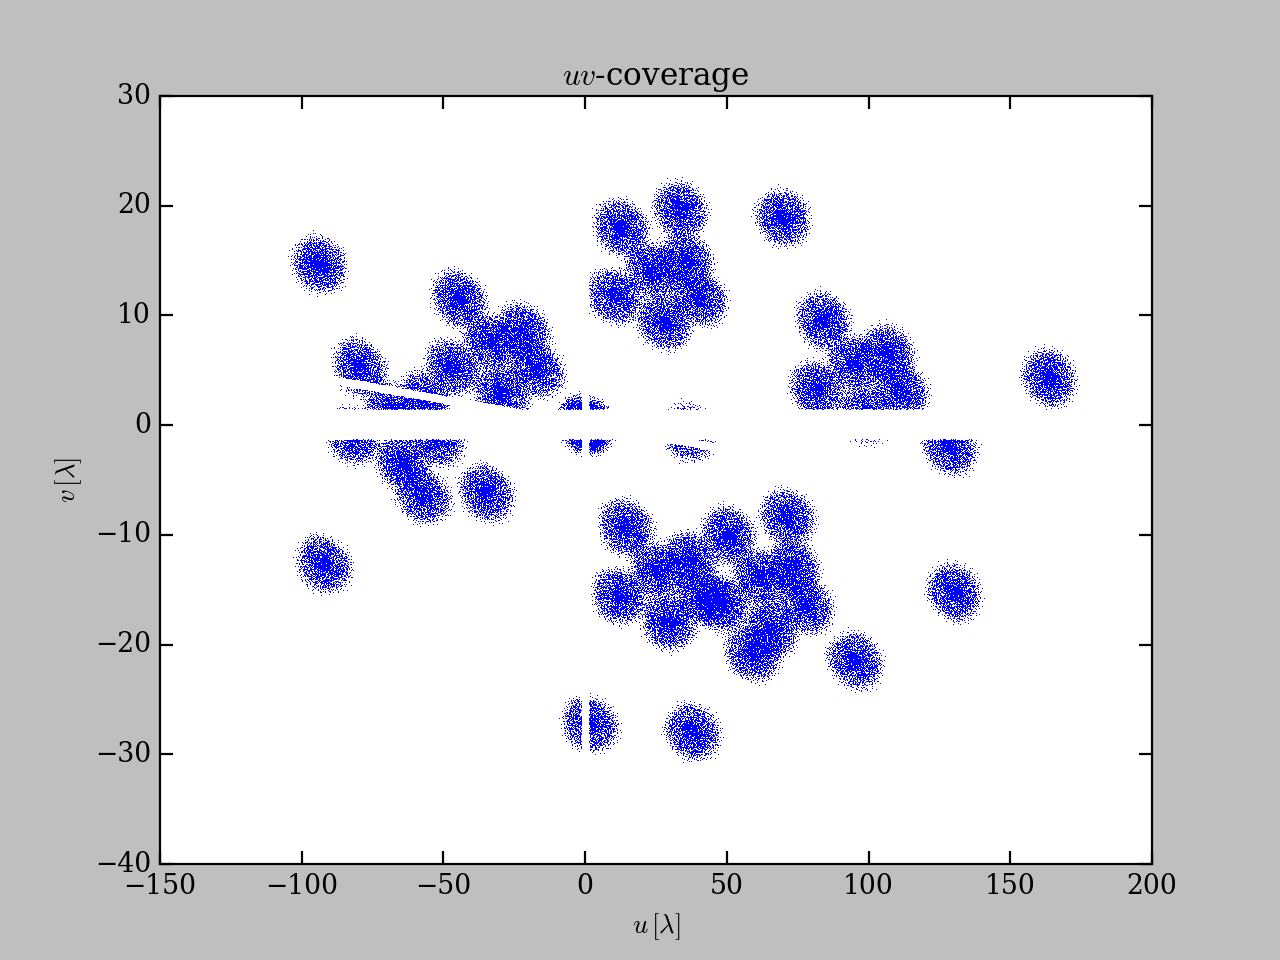

<IPython.core.display.Javascript object>


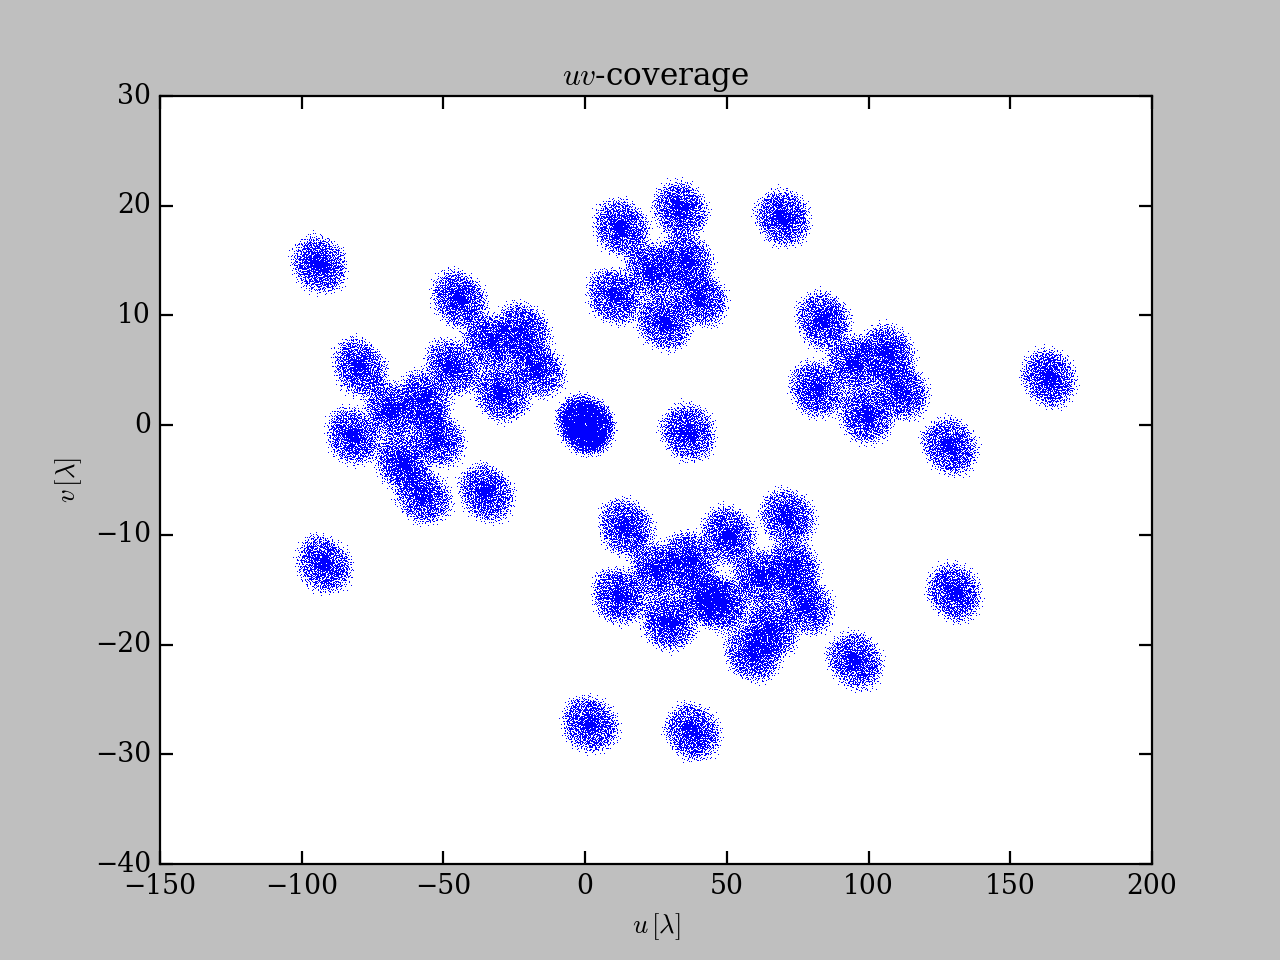

<IPython.core.display.Javascript object>


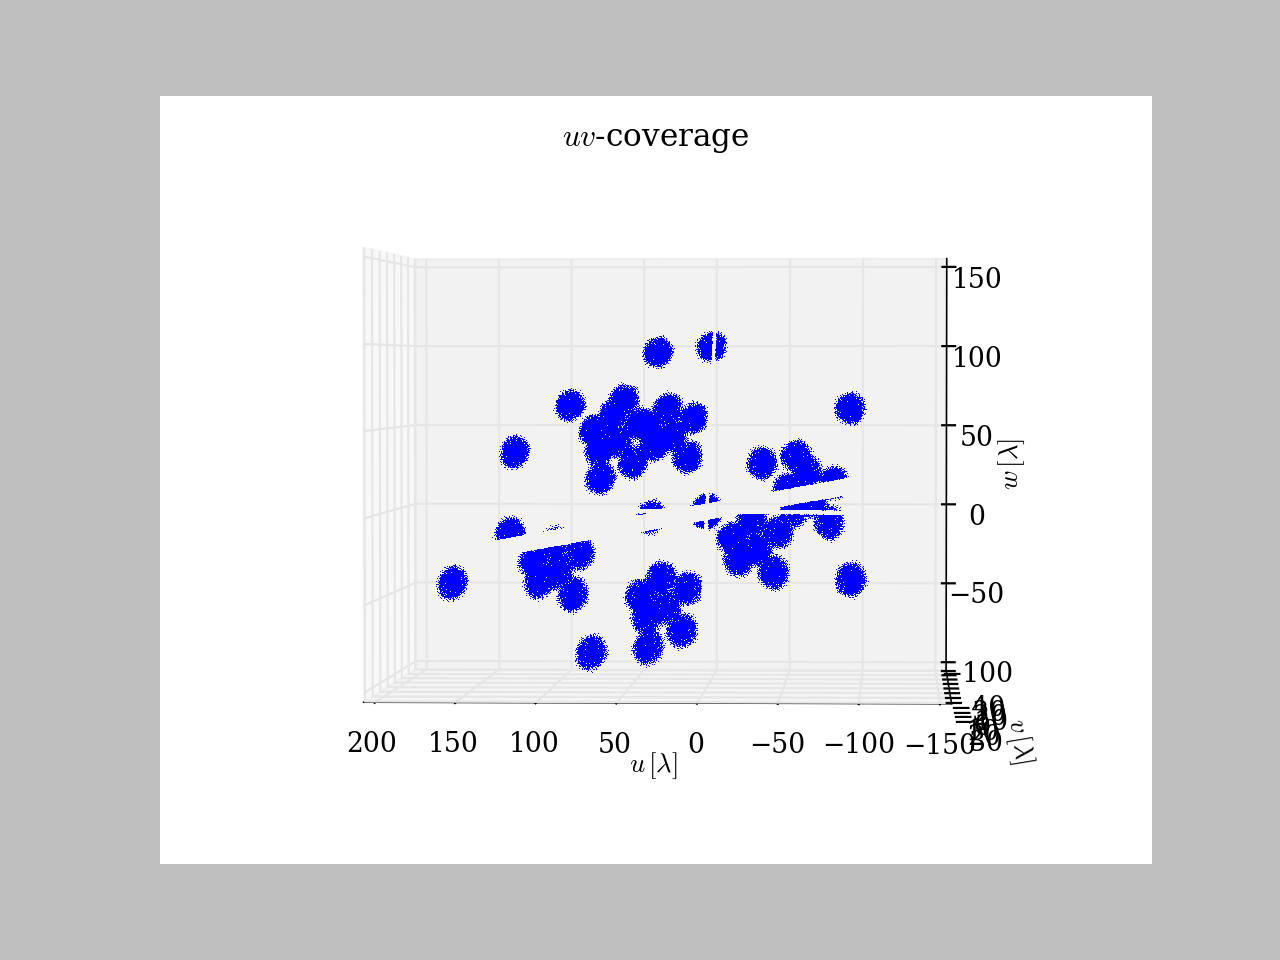

Text(0.5,0,'$w\\,[\\lambda]$')

In [177]:
%matplotlib notebook

# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t.getcol('UVW')[:,0][index]/lmbda,
        t.getcol('UVW')[:,1][index]/lmbda,",")

ax.set_title(r"$uv$-coverage",fontsize=14)
ax.set_xlabel(r"$u\,[\lambda]$",fontsize=12)
ax.set_ylabel(r"$v\,[\lambda]$",fontsize=12)
# ax.set_zlabel(r"$w\,[\lambda]$",fontsize=12)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t.getcol('UVW')[:,0]/lmbda,
        t.getcol('UVW')[:,1]/lmbda,",")

ax.set_title(r"$uv$-coverage",fontsize=14)
ax.set_xlabel(r"$u\,[\lambda]$",fontsize=12)
ax.set_ylabel(r"$v\,[\lambda]$",fontsize=12)
# ax.set_zlabel(r"$w\,[\lambda]$",fontsize=12)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(t.getcol('UVW')[:,0][index]/lmbda,
        t.getcol('UVW')[:,1][index]/lmbda, 
        t.getcol('UVW')[:,2][index]/lmbda,",")

ax.set_title(r"$uv$-coverage",fontsize=14)
ax.set_xlabel(r"$u\,[\lambda]$",fontsize=12)
ax.set_ylabel(r"$v\,[\lambda]$",fontsize=12)
ax.set_zlabel(r"$w\,[\lambda]$",fontsize=12)

In [142]:
ax.plot(t.getcol('UVW')[:,1]/lmbda,
        t.getcol('UVW')[:,2]/lmbda, ",")
ax.plot(t.getcol('UVW')[:,0]/lmbda,
        t.getcol('UVW')[:,2]/lmbda, ",")

In [42]:
t.colnames()

['UVW',
 'FLAG_CATEGORY',
 'WEIGHT',
 'SIGMA',
 'ANTENNA1',
 'ANTENNA2',
 'ARRAY_ID',
 'DATA_DESC_ID',
 'EXPOSURE',
 'FEED1',
 'FEED2',
 'FIELD_ID',
 'FLAG_ROW',
 'INTERVAL',
 'OBSERVATION_ID',
 'PROCESSOR_ID',
 'SCAN_NUMBER',
 'STATE_ID',
 'TIME',
 'TIME_CENTROID',
 'DATA',
 'FLAG',
 'LOFAR_FULL_RES_FLAG',
 'WEIGHT_SPECTRUM']

In [137]:
np.sqrt(len(t.getcol('TIME')))

351.70299970287431

In [103]:
Nu = get_ms_freqs(t)
lmbda = 3.e8/np.mean(Nu)
umin  = 10./lmbda
umax  = 10000/lmbda
du    = 1/lmbda

In [88]:
ls /data/low_band_avg.filter.ms/SPECTRAL_WINDOW

ls: cannot access '/data/low_band_avg.filter.ms/SPECTRAL_WINDOW': No such file or directory
